In [1]:
'''
Primary Objective:

Analyze the spread, trends, and patterns of COVID-19 cases in the U.S.
Identify correlations between public health policies and infection rates.
Possible Deliverables:

Time-series analysis of case trends (daily, weekly, monthly).
Geographical spread visualizations (state-wise heatmaps).
Correlations between key metrics (e.g., vaccination rates vs. cases).
Insights on the effectiveness of interventions (lockdowns, mask mandates).

'''

'\nPrimary Objective:\n\nAnalyze the spread, trends, and patterns of COVID-19 cases in the U.S.\nIdentify correlations between public health policies and infection rates.\nPossible Deliverables:\n\nTime-series analysis of case trends (daily, weekly, monthly).\nGeographical spread visualizations (state-wise heatmaps).\nCorrelations between key metrics (e.g., vaccination rates vs. cases).\nInsights on the effectiveness of interventions (lockdowns, mask mandates).\n\n'

In [2]:
"""
!pip install google-cloud-bigquery 
!pip install pandas 
!pip install matplotlib
!pip install seaborn
!pip install db-dtypes
!pip install numpy==1.22.4
!pip install --force-reinstall scipy==1.6.2
!pip install pathlib
"""
import pandas as pd
import numpy as np
import scipy
import db_dtypes
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from google.cloud import bigquery
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Specify your project ID
project_id = "covid19-data-analytics-project"
dataset_id = "covid19_usa_2020_2023"
table_id = "covid19_usa_2020_2023"

# Initialize BigQuery client with the project ID
client = bigquery.Client(project=project_id)

# Full table path
table_path = f"{project_id}.{dataset_id}.{table_id}"

table = client.get_table(table_path)

# Print all column names
print("Columns in the table:")
for schema_field in table.schema:
    print(schema_field.name)

Columns in the table:
date
location_key
subregion1_code
subregion1_name
country_name
new_confirmed
new_deceased
new_vaccine_doses_administered
cumulative_vaccine_doses_administered
new_persons_fully_vaccinated
stringency_index
population
population_density


In [4]:
query = """
SELECT
    date,
    location_key,
    subregion1_code,
    subregion1_name,
    country_name,
    population,
    new_confirmed,
    new_deceased,
    new_persons_fully_vaccinated
FROM `covid19-data-analytics-project.covid19_usa_2020_2023.covid19_usa_2020_2023`
WHERE country_name = 'United States of America';
"""

# Execute query and load into Pandas DataFrame
df = client.query(query).to_dataframe()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255435 entries, 0 to 3255434
Data columns (total 9 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   date                          dbdate
 1   location_key                  object
 2   subregion1_code               object
 3   subregion1_name               object
 4   country_name                  object
 5   population                    Int64 
 6   new_confirmed                 Int64 
 7   new_deceased                  Int64 
 8   new_persons_fully_vaccinated  Int64 
dtypes: Int64(4), dbdate(1), object(4)
memory usage: 236.0+ MB


In [6]:
df.head(10)

,date,location_key,subregion1_code,subregion1_name,country_name,population,new_confirmed,new_deceased,new_persons_fully_vaccinated
0,2021-07-06,US_AS,AS,American Samoa,United States of America,49710,0,0,0
1,2021-07-06,US_AZ_04005,AZ,Arizona,United States of America,141001,5,0,72
2,2021-07-06,US_AZ_04013,AZ,Arizona,United States of America,4327184,712,8,4104
3,2021-07-06,US_AZ_04019,AZ,Arizona,United States of America,1026391,43,4,873
4,2021-07-06,US_CT_09003,CT,Connecticut,United States of America,893076,45,0,980
5,2021-07-06,US_DE,DE,Delaware,United States of America,989948,12,0,1326
6,2021-07-06,US_DE_10001,DE,Delaware,United States of America,176499,0,0,189
7,2021-07-06,US_MA_25021,MA,Massachusetts,United States of America,700599,26,1,778
8,2021-07-06,US_MA_25023,MA,Massachusetts,United States of America,515461,25,1,573
9,2021-07-06,US_MP_69110,MP,Northern Mariana Islands,United States of America,48220,0,0,<NA>


In [7]:
print(df.isnull().sum())

date                                  0
location_key                          0
subregion1_code                     991
subregion1_name                     991
country_name                          0
population                            0
new_confirmed                    707638
new_deceased                     776972
new_persons_fully_vaccinated    1636575
dtype: int64


In [8]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("Percentage of Missing Values Per Column:")
print(missing_percentage)

Percentage of Missing Values Per Column:
date                             0.000000
location_key                     0.000000
subregion1_code                  0.030441
subregion1_name                  0.030441
country_name                     0.000000
population                       0.000000
new_confirmed                   21.737126
new_deceased                    23.866918
new_persons_fully_vaccinated    50.272083
dtype: float64


In [9]:
df['new_persons_fully_vaccinated'] = df['new_persons_fully_vaccinated'].fillna(0)

print("Missing values after filling:")
print(df['new_persons_fully_vaccinated'].isnull().sum()) 

Missing values after filling:
0


In [10]:
#COVID19 disease progression stage at days 10-14 is Recovery or Escalation
for lag in range(10, 15):
    df[f'new_confirmed_lag_{lag}'] = df.groupby('location_key')['new_confirmed'].shift(lag)
    df[f'new_deceased_lag_{lag}'] = df.groupby('location_key')['new_deceased'].shift(lag)
    
# Verify the new columns
print("New lag columns added:")
print([col for col in df.columns if 'lag' in col])

New lag columns added:
['new_confirmed_lag_10', 'new_deceased_lag_10', 'new_confirmed_lag_11', 'new_deceased_lag_11', 'new_confirmed_lag_12', 'new_deceased_lag_12', 'new_confirmed_lag_13', 'new_deceased_lag_13', 'new_confirmed_lag_14', 'new_deceased_lag_14']


In [11]:
"""Create rolling averages for 10-14 day window
These features captures average trends over a 14-day period
Shifting 10 days offsets the rolling window into the past, 
so the feature reflects values relevant to Days 10–14 prior to the current date."""

df['new_confirmed_10_14_avg'] = df.groupby('location_key')['new_confirmed'].transform(
    lambda x: x.rolling(window=14).mean().shift(10)
)

df['new_deceased_10_14_avg'] = df.groupby('location_key')['new_deceased'].transform(
    lambda x: x.rolling(window=14).mean().shift(10)
)


In [12]:
"""Create rolling sum for 10-14 day window
These features captures cumulative trends over a 14-day period (rolling window)
Shifting 10 days offsets the rolling window into the past, 
so the feature reflects values relevant to Days 10–14 prior to the current date."""

df['new_confirmed_10_14_sum'] = df.groupby('location_key')['new_confirmed'].transform(
    lambda x: x.rolling(window=14).sum().shift(10)
)

df['new_deceased_10_14_sum'] = df.groupby('location_key')['new_deceased'].transform(
    lambda x: x.rolling(window=14).sum().shift(10)
)


In [13]:
# Normalize metrics by population (per 100,000 people)
df['new_confirmed_per_100k'] = (df['new_confirmed'] / df['population']) * 100000
df['new_deceased_per_100k'] = (df['new_deceased'] / df['population']) * 100000


In [14]:
# Calculate vaccination percentage
df['percent_fully_vaccinated'] = (df['new_persons_fully_vaccinated'] / df['population']) * 100

In [15]:
df.columns

Index(['date', 'location_key', 'subregion1_code', 'subregion1_name',
       'country_name', 'population', 'new_confirmed', 'new_deceased',
       'new_persons_fully_vaccinated', 'new_confirmed_lag_10',
       'new_deceased_lag_10', 'new_confirmed_lag_11', 'new_deceased_lag_11',
       'new_confirmed_lag_12', 'new_deceased_lag_12', 'new_confirmed_lag_13',
       'new_deceased_lag_13', 'new_confirmed_lag_14', 'new_deceased_lag_14',
       'new_confirmed_10_14_avg', 'new_deceased_10_14_avg',
       'new_confirmed_10_14_sum', 'new_deceased_10_14_sum',
       'new_confirmed_per_100k', 'new_deceased_per_100k',
       'percent_fully_vaccinated'],
      dtype='object')

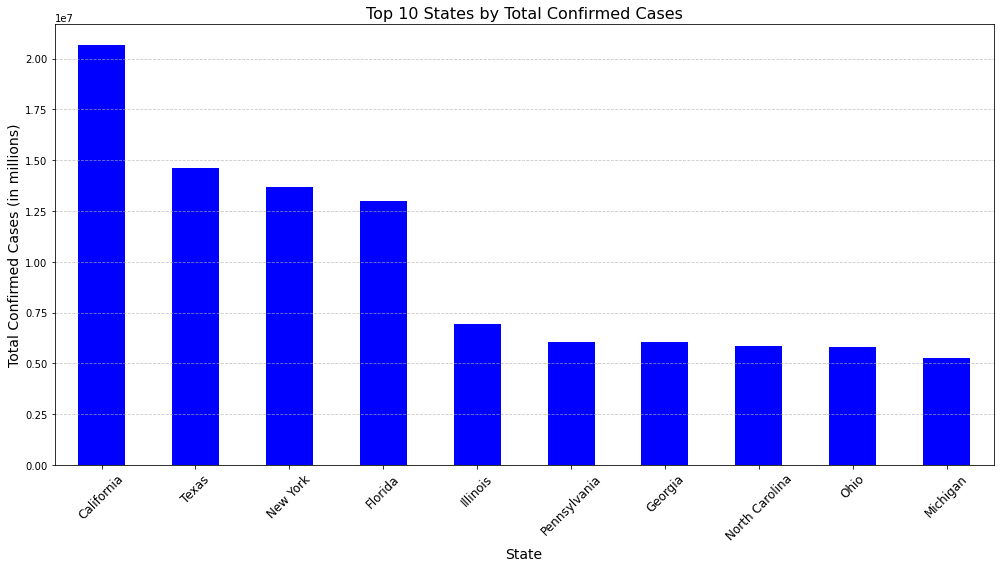

In [16]:
statewise_cases = df.groupby('subregion1_name')['new_confirmed'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
statewise_cases.plot(kind='bar', color='blue')
plt.title('Top 10 States by Total Confirmed Cases', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total Confirmed Cases (in millions)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


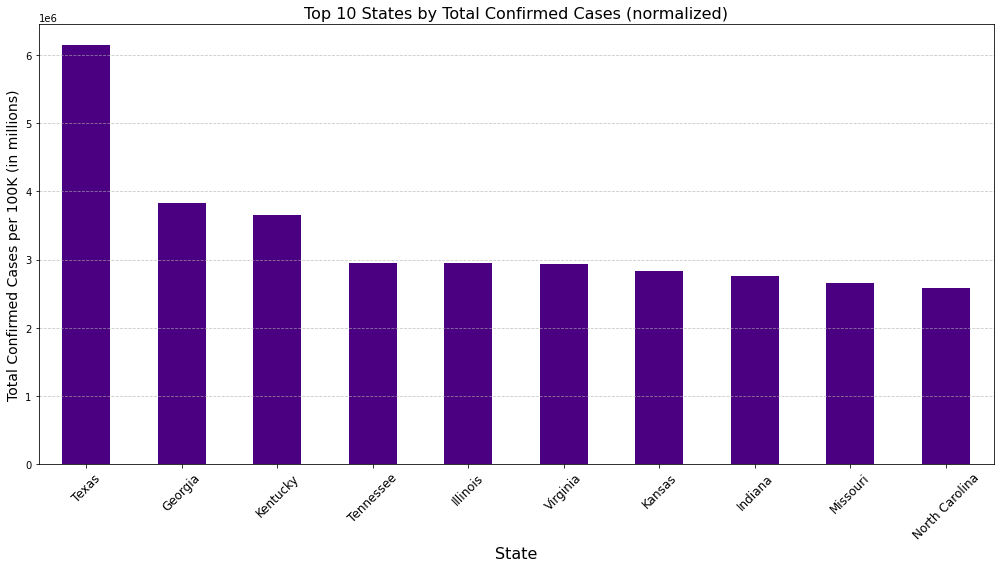

In [17]:
statewise_cases = df.groupby('subregion1_name')['new_confirmed_per_100k'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
statewise_cases.plot(kind='bar', color='indigo')
plt.title('Top 10 States by Total Confirmed Cases (normalized)', fontsize=16)
plt.xlabel('State', fontsize=16)
plt.ylabel('Total Confirmed Cases per 100K (in millions)', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

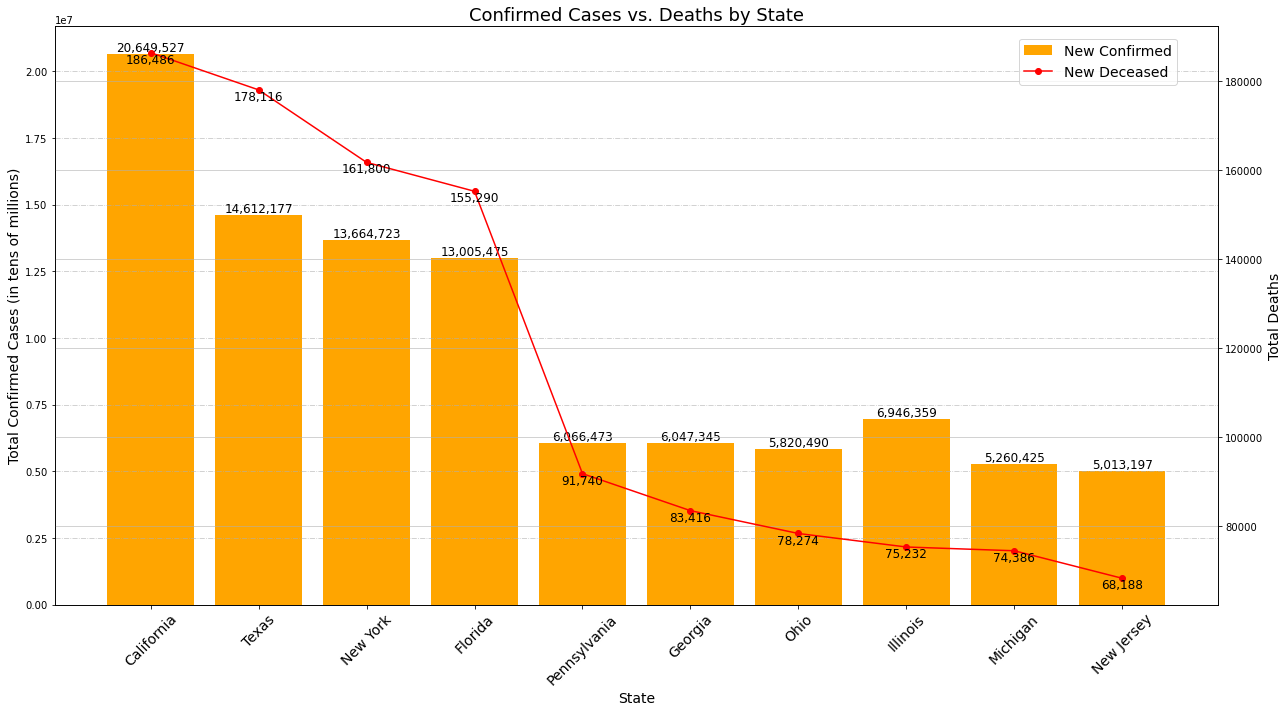

In [18]:
# Grouping by state and calculate sums
statewise_summary = df.groupby('subregion1_name')[['new_confirmed', 'new_deceased']].sum().sort_values(by=['new_deceased', 'new_confirmed'], ascending=False).head(10)

# Converting to NumPy arrays to avoid the multi-dimensional indexing issue
x_values = statewise_summary.index.to_numpy()  # State names
y_confirmed = statewise_summary['new_confirmed'].to_numpy()  # Confirmed cases
y_deceased = statewise_summary['new_deceased'].to_numpy()  # Deaths

# The figure and the plot
fig, ax1 = plt.subplots(figsize=(18, 10))

# Plotting new_confirmed on the primary Y-axis
bar1 = ax1.bar(x_values, y_confirmed, color='orange', label='New Confirmed')
ax1.set_ylabel('Total Confirmed Cases (in tens of millions)', fontsize=14)
ax1.set_xlabel('State', fontsize=14)
ax1.set_title('Confirmed Cases vs. Deaths by State', fontsize=18)
ax1.tick_params(axis='x', rotation=45, labelsize=14)
for i, v in enumerate(y_confirmed):
    ax1.text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=12)

# Plotting new_deceased on the secondary Y-axis using a line plot with markers
ax2 = ax1.twinx()
line1, = ax2.plot(x_values, y_deceased, color='red', marker='o', label='New Deceased')
ax2.set_ylabel('Total Deaths', fontsize=14)
for i, v in enumerate(y_deceased):
        ax2.text(i, v - 3000, f'{v:,}', ha='center', va='bottom', fontsize=12)

# Add legends for both axes
fig.legend([bar1, line1], ['New Confirmed', 'New Deceased'], loc='upper center', bbox_to_anchor=(0.85, 0.95), fontsize=14)

# Add gridlines and layout adjustments
ax1.grid(axis='y', linestyle='-.', alpha=0.7)
ax2.grid(axis='y', linestyle='solid', alpha=0.7)
fig.tight_layout()

plt.show()


In [24]:
# Filter for required columns
features = ['new_deceased',
       'new_persons_fully_vaccinated', 'new_confirmed_lag_10',
       'new_deceased_lag_10', 'new_confirmed_lag_11', 'new_deceased_lag_11',
       'new_confirmed_lag_12', 'new_deceased_lag_12', 'new_confirmed_lag_13',
       'new_deceased_lag_13', 'new_confirmed_lag_14', 'new_deceased_lag_14',
       'new_confirmed_10_14_avg', 'new_deceased_10_14_avg',
       'new_confirmed_10_14_sum', 'new_deceased_10_14_sum',
       'new_confirmed_per_100k', 'new_deceased_per_100k',
       'percent_fully_vaccinated'
]

target = 'new_confirmed'

# Extract features and target
X = df[features]
y = df[target]

# Perform 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Confirm the shapes
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)


Train features shape: (2278804, 19)
Train target shape: (2278804,)
Test features shape: (976631, 19)
Test target shape: (976631,)


In [25]:
# Ensure all feature columns are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = y_train.apply(pd.to_numeric, errors='coerce')
y_test = y_test.apply(pd.to_numeric, errors='coerce')

# Check for non-numeric columns (should return empty if all are numeric)
print("Non-numeric columns in X_train:", X_train.select_dtypes(exclude=['number']).columns)
print("Non-numeric columns in X_test:", X_test.select_dtypes(exclude=['number']).columns)
print("Non-numeric columns in y_train:", y_train.dtype)
print("Non-numeric columns in y_test:", y_test.dtype)

Non-numeric columns in X_train: Index([], dtype='object')
Non-numeric columns in X_test: Index([], dtype='object')
Non-numeric columns in y_train: float64
Non-numeric columns in y_test: float64


In [26]:
# Explicitly convert all features to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Convert target variables to float64
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Confirm data types
print("X_train dtypes after conversion:")
print(X_train.dtypes)

print("\nX_test dtypes after conversion:")
print(X_test.dtypes)

print("y_train dtype:", y_train.dtypes)
print("y_test dtype:", y_test.dtypes)


X_train dtypes after conversion:
new_deceased                    float64
new_persons_fully_vaccinated    float64
new_confirmed_lag_10            float64
new_deceased_lag_10             float64
new_confirmed_lag_11            float64
new_deceased_lag_11             float64
new_confirmed_lag_12            float64
new_deceased_lag_12             float64
new_confirmed_lag_13            float64
new_deceased_lag_13             float64
new_confirmed_lag_14            float64
new_deceased_lag_14             float64
new_confirmed_10_14_avg         float64
new_deceased_10_14_avg          float64
new_confirmed_10_14_sum         float64
new_deceased_10_14_sum          float64
new_confirmed_per_100k          float64
new_deceased_per_100k           float64
percent_fully_vaccinated        float64
dtype: object

X_test dtypes after conversion:
new_deceased                    float64
new_persons_fully_vaccinated    float64
new_confirmed_lag_10            float64
new_deceased_lag_10             float64


In [27]:
# Replace NaN and Infinite values with zeros or a placeholder value
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
y_train = y_train.replace([np.inf, -np.inf], np.nan).fillna(0)
y_test = y_test.replace([np.inf, -np.inf], np.nan).fillna(0)

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Sample 20% of the training data
X_sample = X_train.sample(frac=0.2, random_state=42)
y_sample = y_train.loc[X_sample.index]

# Apply RFE with optimized step size
rfe = RFE(estimator=rf, n_features_to_select=5, step=2)
rfe.fit(X_sample, y_sample)

# Get selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['new_deceased', 'new_deceased_10_14_avg', 'new_deceased_10_14_sum',
       'new_confirmed_per_100k', 'new_deceased_per_100k'],
      dtype='object')


In [29]:
# Use only the selected features
X_train_selected = X_train[['new_deceased', 'new_deceased_10_14_avg', 
                            'new_deceased_10_14_sum', 'new_confirmed_per_100k', 
                            'new_deceased_per_100k']]
X_test_selected = X_test[['new_deceased', 'new_deceased_10_14_avg', 
                          'new_deceased_10_14_sum', 'new_confirmed_per_100k', 
                          'new_deceased_per_100k']]

In [33]:
# Initialize and train the model
rf_optimized = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_optimized.fit(X_train_selected, y_train)

# Make predictions
y_pred_optimized = rf_optimized.predict(X_test_selected)


In [31]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_optimized)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
r2 = r2_score(y_test, y_pred_optimized)

print("Optimized Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Optimized Model Performance:
Mean Absolute Error (MAE): 27.215633490960098
Root Mean Squared Error (RMSE): 318.6759021099685
R-squared (R²): 0.8557272286228401


In [34]:
# Feature importance
feature_importances = rf_optimized.feature_importances_

# Use the original feature names from the DataFrame
feature_names = [ 
    'new_deceased', 'new_deceased_10_14_avg', 
                            'new_deceased_10_14_sum', 'new_confirmed_per_100k', 
                            'new_deceased_per_100k'
]


# Print feature importance
for feature, importance in zip(feature_names, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")


Feature: new_deceased, Importance: 0.41395063501899154
Feature: new_deceased_10_14_avg, Importance: 0.02694381910755916
Feature: new_deceased_10_14_sum, Importance: 0.033989600708255345
Feature: new_confirmed_per_100k, Importance: 0.4930089127356747
Feature: new_deceased_per_100k, Importance: 0.03210703242951914


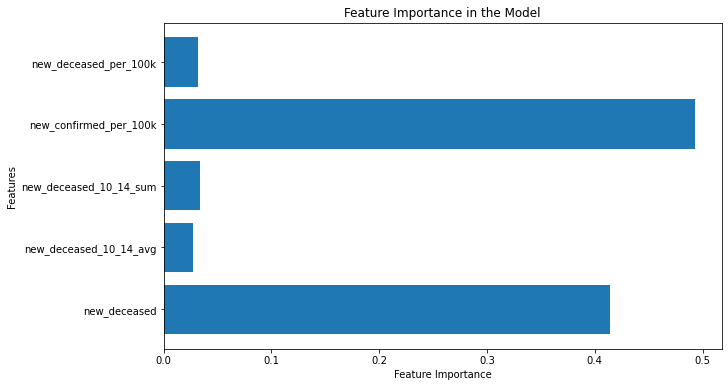

In [37]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_optimized.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in the Model')
plt.show()


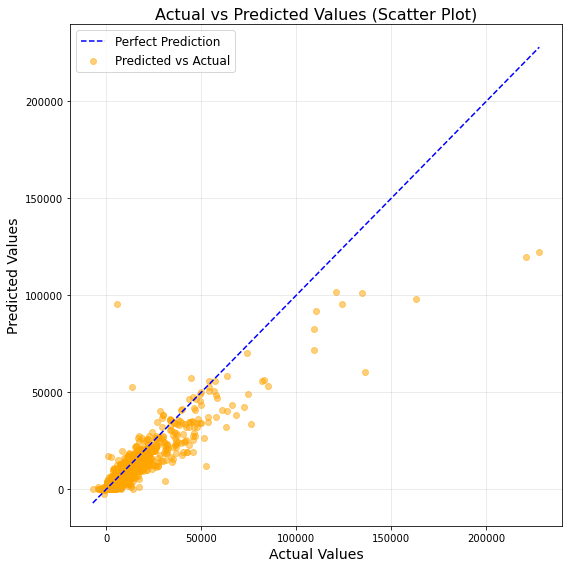

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_optimized, alpha=0.5, color='orange', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', label='Perfect Prediction')  # Diagonal line
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs Predicted Values (Scatter Plot)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()